In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utility_functions import *
from weight_matrix import *
from parameters import *
import glob
from phi import *
import re
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.ephys.extract_cell_features import extract_cell_features
from collections import defaultdict
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor


In [2]:
def power_law_helper(V, gain, A):
    return fit_power_law(V, gain, A, thres)

def fit_power_law(V, gain, A, thres):
    return np.maximum(gain*(V - thres), 0)**A

def fit_exponential(V, thres, gain):
    return np.exp( gain*(V-thres) )

In [3]:
cell_id1 = np.array([562965437, 558076716, 510395901, 510106222, 504635521])  # 522301604 (2)
cell_id2 = np.array([518271679, 517645929, 490283114, 484737013, 480364000, 480008325, 480003970, 478888052, 464079491, 354190013, 325479788, 325158873])
cell_id3 = np.array([518290966, 518287095, 518238899, 517982558, 517981878, 517647182, 507770911, 506777471, 505847801, 502829071, 490283519, 490267219, 490263211, 484738748, 483109334, 483068687, 480647923, 480011594, 479993900, 478892782, 478888083, 476056333, 476054887, 476054829, 475751758, 469661756, 467831649, 467703703, 349621141, 349593629, 348592897, 325471170, 325464516, 324521027, 320668879, 320668841, 313862022])
cell_id4 = np.array([594611511, 594594470, 593646143, 592833901, 592816620, 591626585, 591622050, 591517805, 585080288, 584561230, 582917630, 582641339, 576411497, 576046388, 575937040, 575923740, 571255047, 570896453, 570589704, 570014498, 565880475, 497499510])
cell_id5 = np.array([559104842, 535520969, 530325234, 528501887, 527116037, 526951157, 526946778, 526643573, 515464483, 515462796, 515435668, 512322162, 512319604, 510136749, 509881736, 502383543, 502367941, 501850666])  # 559388218(0)
cell_id6 = np.array([626159623, 589764355, 589121138, 558476932, 556669671])

print(len(cell_id1), len(cell_id2), len(cell_id3), len(cell_id4), len(cell_id5), len(cell_id6))

5 12 37 22 18 5


In [4]:
# initialize the cache
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

v_thres_all = np.zeros((len(cell_id1), ))
v_reset_all = np.zeros((len(cell_id1), ))
output_filename = 'cell_id1.npz'

for cid in range(len(cell_id1)):
    
    # pick a cell to analyze
    specimen_id = cell_id1[cid]

    # download the ephys data and sweep metadata
    data_set = ctc.get_ephys_data(specimen_id)
    sweeps = ctc.get_ephys_sweeps(specimen_id)

    # group the sweeps by stimulus 
    sweep_numbers = defaultdict(list)

    for sweep in sweeps:
        sweep_numbers[sweep['stimulus_name']].append(sweep['sweep_number'])
    
    # Extract all long square stimulation sweeps
    long_square_sweeps = sweep_numbers['Long Square']
    
    v_mean = np.zeros((len(long_square_sweeps), ))
    fr_mean = np.zeros((len(long_square_sweeps), ))
    v_thres = np.zeros((len(long_square_sweeps), ))
    v_reset = np.zeros((len(long_square_sweeps), ))
    
    for i in range(len(long_square_sweeps)):
        sweep_data = data_set.get_sweep(long_square_sweeps[i])

        index_range = sweep_data["index_range"]
        input_curr = sweep_data["stimulus"][0:index_range[1]+1] # in A
        memVol = sweep_data["response"][0:index_range[1]+1] # in V
        input_curr *= 1e12 # to pA
        memVol *= 1e3 # to mV

        sampling_rate = sweep_data["sampling_rate"] # in Hz
        time_s = np.arange(0, len(memVol)) * (1.0 / sampling_rate)

        sweep_ext = EphysSweepFeatureExtractor(t=time_s, v=memVol, i=input_curr, start=1.02, end=2.02)
        sweep_ext.process_spikes()

        idx_spike = sweep_ext.spike_feature("threshold_index").astype(int)
        idx_trough = sweep_ext.spike_feature("trough_index").astype(int)
        idx_start = np.where(np.abs(time_s - 1.02) <= (1.0 / sampling_rate))[0][0]
        idx_end = np.where(np.abs(time_s - 2.02) <= (1.0 / sampling_rate))[0][0]
        
        if len(idx_spike) == len(idx_trough):
            if len(idx_spike) == 0:
                v_temp = np.nanmean(memVol[idx_start:idx_end])
                fr_temp = 0
            else:
                v_temp =np.array([])
                for j in range(len(idx_spike)):
                    if j == 0:
                        v_temp = np.append(v_temp, memVol[idx_start:idx_spike[j]])
                    elif j == (len(idx_spike)-1):
                        v_temp = np.append(v_temp, memVol[idx_trough[j-1]:idx_end])
                    else:
                        v_temp = np.append(v_temp, memVol[idx_trough[j-1]:idx_spike[j]])
        else:
            v_temp =np.array([])
            for j in range(len(idx_trough)):
                if j == 0:
                    v_temp = np.append(v_temp, memVol[idx_start:idx_spike[j]])
                elif j == (len(idx_spike)-1):
                    v_temp = np.append(v_temp, memVol[idx_trough[j]:idx_end])
                else:
                    v_temp = np.append(v_temp, memVol[idx_trough[j-1]:idx_spike[j]])
        
        v_mean[i] = np.nanmean(v_temp)
        fr_mean[i] = len(idx_spike) / 1
#         if np.isnan(v_mean[i]):
#             import pdb; pdb.set_trace()
        
        v_thres[i] = np.nanmean(memVol[idx_spike])
        v_reset[i] = np.nanmean(memVol[idx_trough])
    
    v_thres_all[cid] = np.nanmean(v_thres)
    v_reset_all[cid] = np.nanmean(v_reset)
    print(cid)

# np.savez(output_filename, v_thres_all, v_reset_all)

/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice


0


/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: Mean of empty slice
/Users/siddharthpaliwal/miniconda3/envs/allensdk/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: Mean of empty slice


1


OSError: Unable to open file (truncated file: eof = 4501504, sblock->base_addr = 0, stored_eof = 10820289)

In [4]:
# initialize the cache
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# pick a cell to analyze
specimen_id = 518287095

# download the ephys data and sweep metadata
data_set = ctc.get_ephys_data(specimen_id)
sweeps = ctc.get_ephys_sweeps(specimen_id)

# group the sweeps by stimulus 
sweep_numbers = defaultdict(list)

for sweep in sweeps:
    sweep_numbers[sweep['stimulus_name']].append(sweep['sweep_number'])

# Extract all long square stimulation sweeps
long_square_sweeps = sweep_numbers['Long Square']

v_mean = np.zeros((len(long_square_sweeps), ))
fr_mean = np.zeros((len(long_square_sweeps), ))

v_save = []
for i in range(len(long_square_sweeps)):
    sweep_data = data_set.get_sweep(long_square_sweeps[i])

    index_range = sweep_data["index_range"]
    input_curr = sweep_data["stimulus"][0:index_range[1]+1] # in A
    memVol = sweep_data["response"][0:index_range[1]+1] # in V
    input_curr *= 1e12 # to pA
    memVol *= 1e3 # to mV

    sampling_rate = sweep_data["sampling_rate"] # in Hz
    time_s = np.arange(0, len(memVol)) * (1.0 / sampling_rate)

    sweep_ext = EphysSweepFeatureExtractor(t=time_s, v=memVol, i=input_curr, start=1.02, end=2.02)
    sweep_ext.process_spikes()

    idx_spike = sweep_ext.spike_feature("threshold_index").astype(int)
    idx_trough = sweep_ext.spike_feature("trough_index").astype(int)
    idx_start = np.where(np.abs(time_s - 1.02) <= (1.0 / sampling_rate))[0][0]
    idx_end = np.where(np.abs(time_s - 2.02) <= (1.0 / sampling_rate))[0][0]

    if len(idx_spike) == len(idx_trough):
        if len(idx_spike) == 0:
            v_temp = np.nanmean(memVol[idx_start:idx_end])
            fr_temp = 0
        else:
            v_temp =np.array([])
            for j in range(len(idx_spike)+1):
                if j == 0:
                    v_temp = np.append(v_temp, memVol[idx_start:idx_spike[j]])
                elif j == (len(idx_spike)):
                    v_temp = np.append(v_temp, memVol[idx_trough[j-1]:idx_end])
                else:
                    v_temp = np.append(v_temp, memVol[idx_trough[j-1]:idx_spike[j]])
    else:
        v_temp =np.array([])
        for j in range(len(idx_trough)):
            if j == 0:
                v_temp = np.append(v_temp, memVol[idx_start:idx_spike[j]])
            elif j == (len(idx_spike)-1):
                v_temp = np.append(v_temp, memVol[idx_trough[j]:idx_end])
            else:
                v_temp = np.append(v_temp, memVol[idx_trough[j-1]:idx_spike[j]])
    v_save = np.append(v_save, v_temp)
    v_mean[i] = np.nanmean(v_temp)
    fr_mean[i] = len(idx_spike) / 1

In [5]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit_exponential, v_mean, fr_mean, bounds=([-70, 0], [-20, 10]))

In [6]:
thres = v_mean[np.where(fr_mean > 0)[0][0] - 1]
popt1, pcov1 = curve_fit(power_law_helper, v_mean, fr_mean, bounds=([0, 0], [10, 10]))

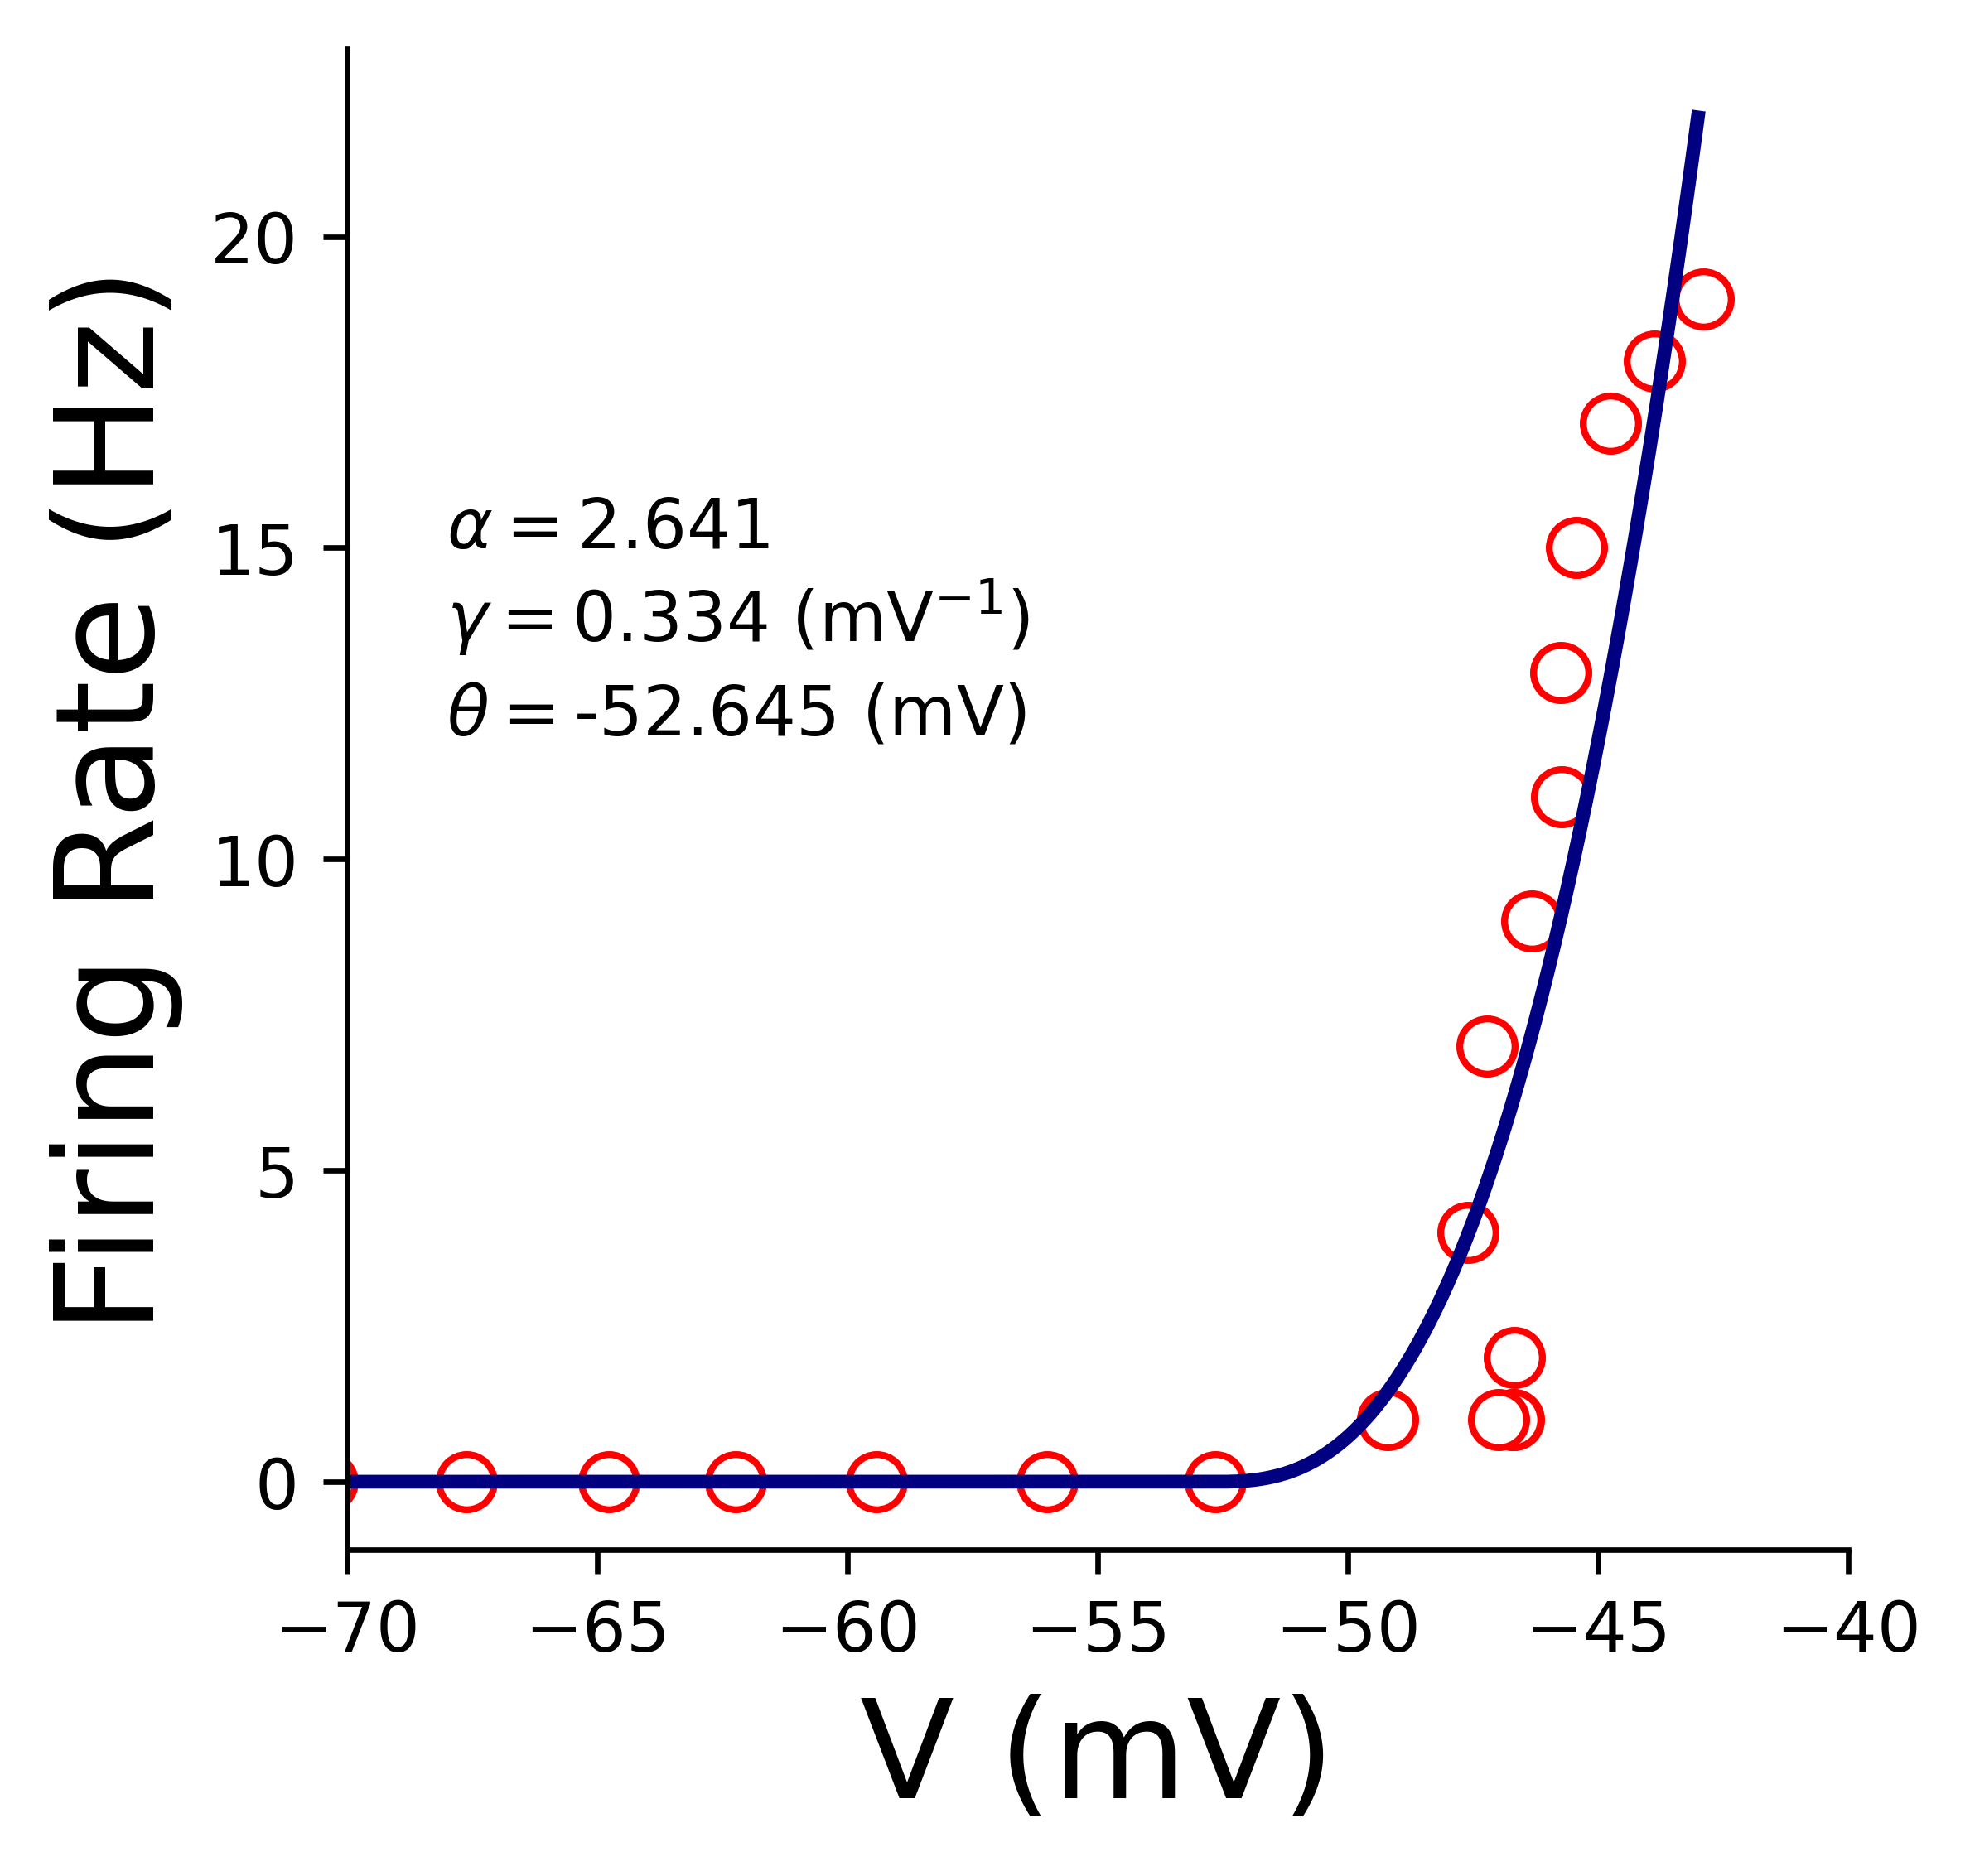

In [22]:
fontsize=20
f,ax=plt.subplots(1,1,dpi=600)
ax.plot(v_mean, fr_mean, 'or', markersize=8,markerfacecolor='white')
xdata = np.linspace(-85, -43, 1000)
# ax.plot(xdata, fit_exponential(xdata, popt[0], popt[1]))
ax.plot(xdata, fit_power_law(xdata, popt1[0], popt1[1], thres),color='navy',linewidth=2)

ax.text(-68, 15, '$\\alpha=$'+str(popt1[1].round(3)), fontsize=10)
ax.text(-68, 13.5, '$\\gamma=$'+str(popt1[0].round(3))+' (mV$^{-1}$)', fontsize=10)
ax.text(-68, 12, '$\\theta=$'+str(thres.round(3))+' (mV)', fontsize=10)
# ax.text(-68, 10, '$\\gamma_{exp}=$'+str(popt[1].round(3))+' (mV$^{-1}$)', fontsize=6)
# ax.text(-68, 8.5, '$\\theta_{exp}=$'+str(popt[0].round(3))+' (mV)', fontsize=6)
ax.set_xlabel('V (mV)',fontsize=fontsize)
ax.set_ylabel('Firing Rate (Hz)',fontsize=fontsize)
ax.set_xlim(-70, -40)
ax.legend(frameon=False, loc='upper left', fontsize=fontsize)
ax.set_aspect(1./ax.get_data_ratio())
sns.despine(f)

In [8]:
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')
# pick a cell to analyze
specimen_id = 518287095

# download the ephys data and sweep metadata
data_set = ctc.get_ephys_data(specimen_id)
sweeps = ctc.get_ephys_sweeps(specimen_id)

# group the sweeps by stimulus 
sweep_numbers = defaultdict(list)

for sweep in sweeps:
    sweep_numbers[sweep['stimulus_name']].append(sweep['sweep_number'])

# Extract all long suaure stimulation sweeps
long_square_sweeps = sweep_numbers['Long Square']
sweep_data = data_set.get_sweep(long_square_sweeps[18])

index_range = sweep_data["index_range"]
i = sweep_data["stimulus"][0:index_range[1]+1] # in A
v = sweep_data["response"][0:index_range[1]+1] # in V
i *= 1e12 # to pA
v *= 1e3 # to mV

sampling_rate = sweep_data["sampling_rate"] # in Hz
t = np.arange(0, len(v)) * (1.0 / sampling_rate)

sweep_ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
sweep_ext.process_spikes()

idx_spike_times = sweep_ext.spike_feature("threshold_index").astype(int)
idx_trough = sweep_ext.spike_feature("trough_index").astype(int)

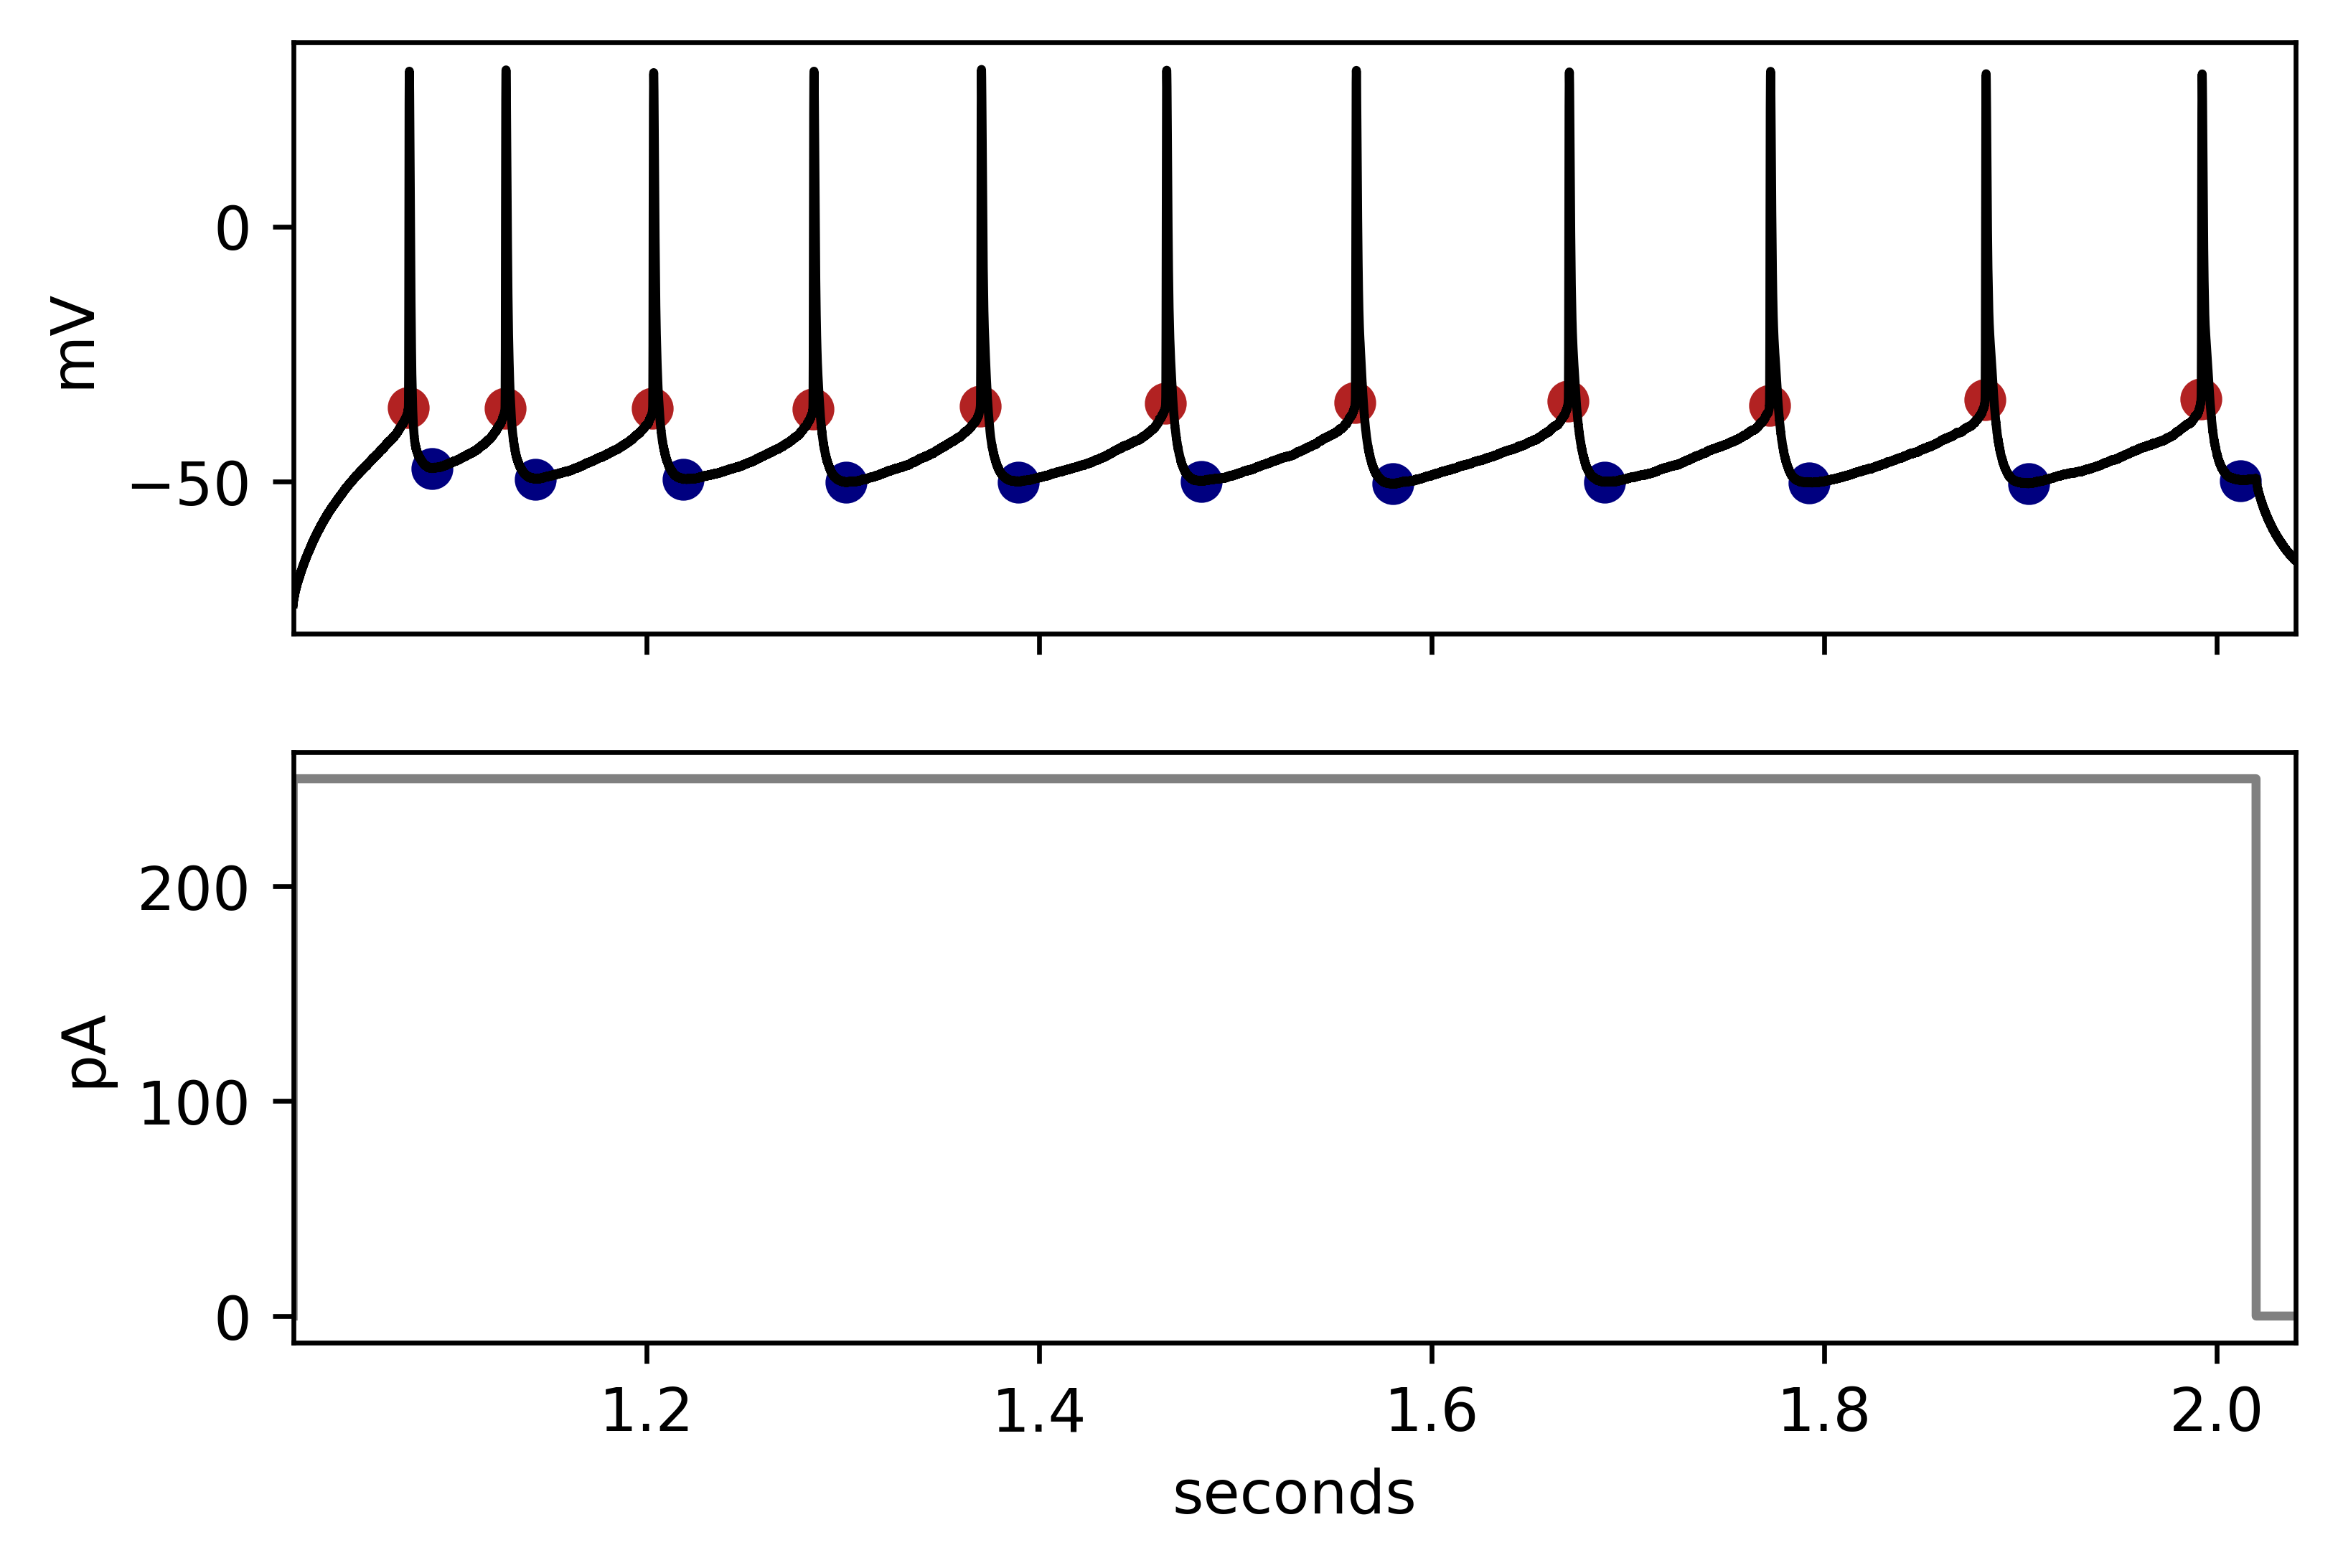

In [9]:
fig, axes = plt.subplots(2, 1, dpi=600,sharex=True)
axes[0].plot(t[index_range[0]:index_range[1]], v[index_range[0]:index_range[1]], color='black')
axes[1].plot(t[index_range[0]:index_range[1]], i[index_range[0]:index_range[1]], color='gray')
axes[0].scatter(t[idx_spike_times], v[idx_spike_times], c='firebrick')
axes[0].scatter(t[idx_trough], v[idx_trough], c='navy')
axes[0].set_ylabel("mV")
axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")
axes[0].set_xlim(1.02, 2.04)
axes[1].set_xlim(1.02, 2.04)
plt.show()

In [13]:
t0 = 0
t1 = 10
dt = 0.01
T = np.arange(t0, t1+dt, dt)
V = 0.0
E = 2.1 + np.random.uniform(0,1,size=(len(T), ))
A = 2
memVol = np.zeros((len(T), ))
spkTrain = np.zeros((len(T)))
memVol[0] = V
spks=0
np.random.seed(4546865)
for k in range(len(T)-1):

    V += dt * (-V + E[k]) - V * spks
    r = np.maximum(V-1, 0)**A
    if r > 1/dt:
        r = 1/dt
    spks = np.random.binomial(n=1, p=r*dt, size=(1, ))

    memVol[k+1] = V
    spkTrain[k+1] = spks


In [23]:
file_in_folder = sorted(glob.glob('/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 1/*.np[yz]'))
file_in_folder1 = sorted(glob.glob('../Data/*.np[yz]'))
idx = [1, 4, 3, 5, 2, 0]

mean_thres_exp = np.zeros((len(file_in_folder), ))
mean_gain_exp = np.zeros((len(file_in_folder), ))
mean_exponent_pl = np.zeros((len(file_in_folder), ))
mean_gain_pl = np.zeros((len(file_in_folder), ))
mean_threshold_pl = np.zeros((len(file_in_folder), ))
mean_gain_rescaled_pl = np.zeros((len(file_in_folder), ))
mean_gain_rescaled_exp = np.zeros((len(file_in_folder), ))

var_thres_exp = np.zeros((len(file_in_folder), ))
var_gain_exp = np.zeros((len(file_in_folder), ))
var_gain_rescaled_exp = np.zeros((len(file_in_folder), ))
var_exponent_pl = np.zeros((len(file_in_folder), ))
var_gain_pl = np.zeros((len(file_in_folder), ))
var_threshold_pl = np.zeros((len(file_in_folder), ))
var_gain_rescaled_pl = np.zeros((len(file_in_folder), ))

for i in range(len(file_in_folder)):
    
    data = np.load(file_in_folder[idx[i]])
    data1 = np.load(file_in_folder1[i])
    
    if i == 0:
        thres_pl = np.concatenate((data['arr_0'][0:2], data['arr_0'][3:]))
        exponent_pl = np.concatenate((data['arr_2'][0:2], data['arr_2'][3:]))
        gain_pl = np.concatenate((data['arr_1'][0:2], data['arr_1'][3:]))
        thres_exp = np.concatenate((data['arr_3'][0:2], data['arr_3'][3:]))
        gain_exp = np.concatenate((data['arr_4'][0:2], data['arr_4'][3:]))
        v_thres_exp = data1['arr_0']
        v_reset_exp = data1['arr_1']
        v_thres_pl = data1['arr_0']
        v_reset_pl = data1['arr_1']
    elif i == 3:
        thres_pl = np.concatenate((data['arr_0'][0:8], data['arr_0'][9:]))
        exponent_pl = np.concatenate((data['arr_2'][0:8], data['arr_2'][9:]))
        gain_pl = np.concatenate((data['arr_1'][0:8], data['arr_1'][9:]))
        thres_exp = data['arr_3']
        gain_exp = data['arr_4']
        v_thres_exp = data1['arr_0']
        v_reset_exp = data1['arr_1']
        v_thres_pl = np.concatenate((data1['arr_0'][0:8], data1['arr_0'][9:]))
        v_reset_pl = np.concatenate((data1['arr_1'][0:8], data1['arr_1'][9:]))
    elif i == 4:
        thres_pl = data['arr_0'][1:]
        exponent_pl = data['arr_2'][1:]
        gain_pl = data['arr_1'][1:]
        thres_exp = data['arr_3'][1:]
        gain_exp = data['arr_4'][1:]
        v_thres_exp = data1['arr_0']
        v_reset_exp = data1['arr_1']
        v_thres_pl = data1['arr_0']
        v_reset_pl = data1['arr_1']
    else:
        thres_pl = data['arr_0']
        exponent_pl = data['arr_2']
        gain_pl = data['arr_1']
        thres_exp = data['arr_3']
        gain_exp = data['arr_4']
        v_thres_exp = data1['arr_0']
        v_reset_exp = data1['arr_1']
        v_thres_pl = data1['arr_0']
        v_reset_pl = data1['arr_1']
    
    mean_thres_exp[i] = np.nanmean(thres_exp)
    mean_gain_exp[i] = np.nanmean(gain_exp)
    mean_gain_rescaled_exp[i] = np.nanmean(gain_exp * (v_thres_exp - v_reset_exp))
    var_thres_exp[i] = np.nanstd(thres_exp) / np.sqrt(len(thres_exp))
    var_gain_exp[i] = np.nanstd(gain_exp) / np.sqrt(len(gain_exp))
    var_gain_rescaled_exp[i] = np.nanstd(gain_exp * (v_thres_exp - v_reset_exp)) / np.sqrt(len(gain_exp))
    
    mean_exponent_pl[i] = np.nanmean(exponent_pl)
    mean_gain_pl[i] = np.nanmean(gain_pl)
    mean_gain_rescaled_pl[i] = np.nanmean(gain_pl * (v_thres_pl - v_reset_pl))
    mean_threshold_pl[i] = np.nanmean(thres_pl)
    var_exponent_pl[i] = np.nanstd(exponent_pl) / np.sqrt(len(thres_pl))
    var_gain_pl[i] = np.nanstd(gain_pl) / np.sqrt(len(gain_pl))
    var_gain_rescaled_pl[i] = np.nanstd(gain_pl * (v_thres_pl - v_reset_pl)) / np.sqrt(len(gain_pl))
    var_threshold_pl[i] = np.nanstd(thres_pl) / np.sqrt(len(thres_pl))

#     if idx[i] == 5:
        
#     else:
#         mean_exponent_pl[i] = np.nanmean(data['arr_2'])
#         mean_gain_pl[i] = np.nanmean(data['arr_1'])
#         var_exponent_pl[i] = np.nanstd(data['arr_2']) / np.sqrt(len(data['arr_2']))
#         var_gain_pl[i] = np.nanstd(data['arr_1']) / np.sqrt(len(data['arr_1']))


KeyError: 'arr_0 is not a file in the archive'

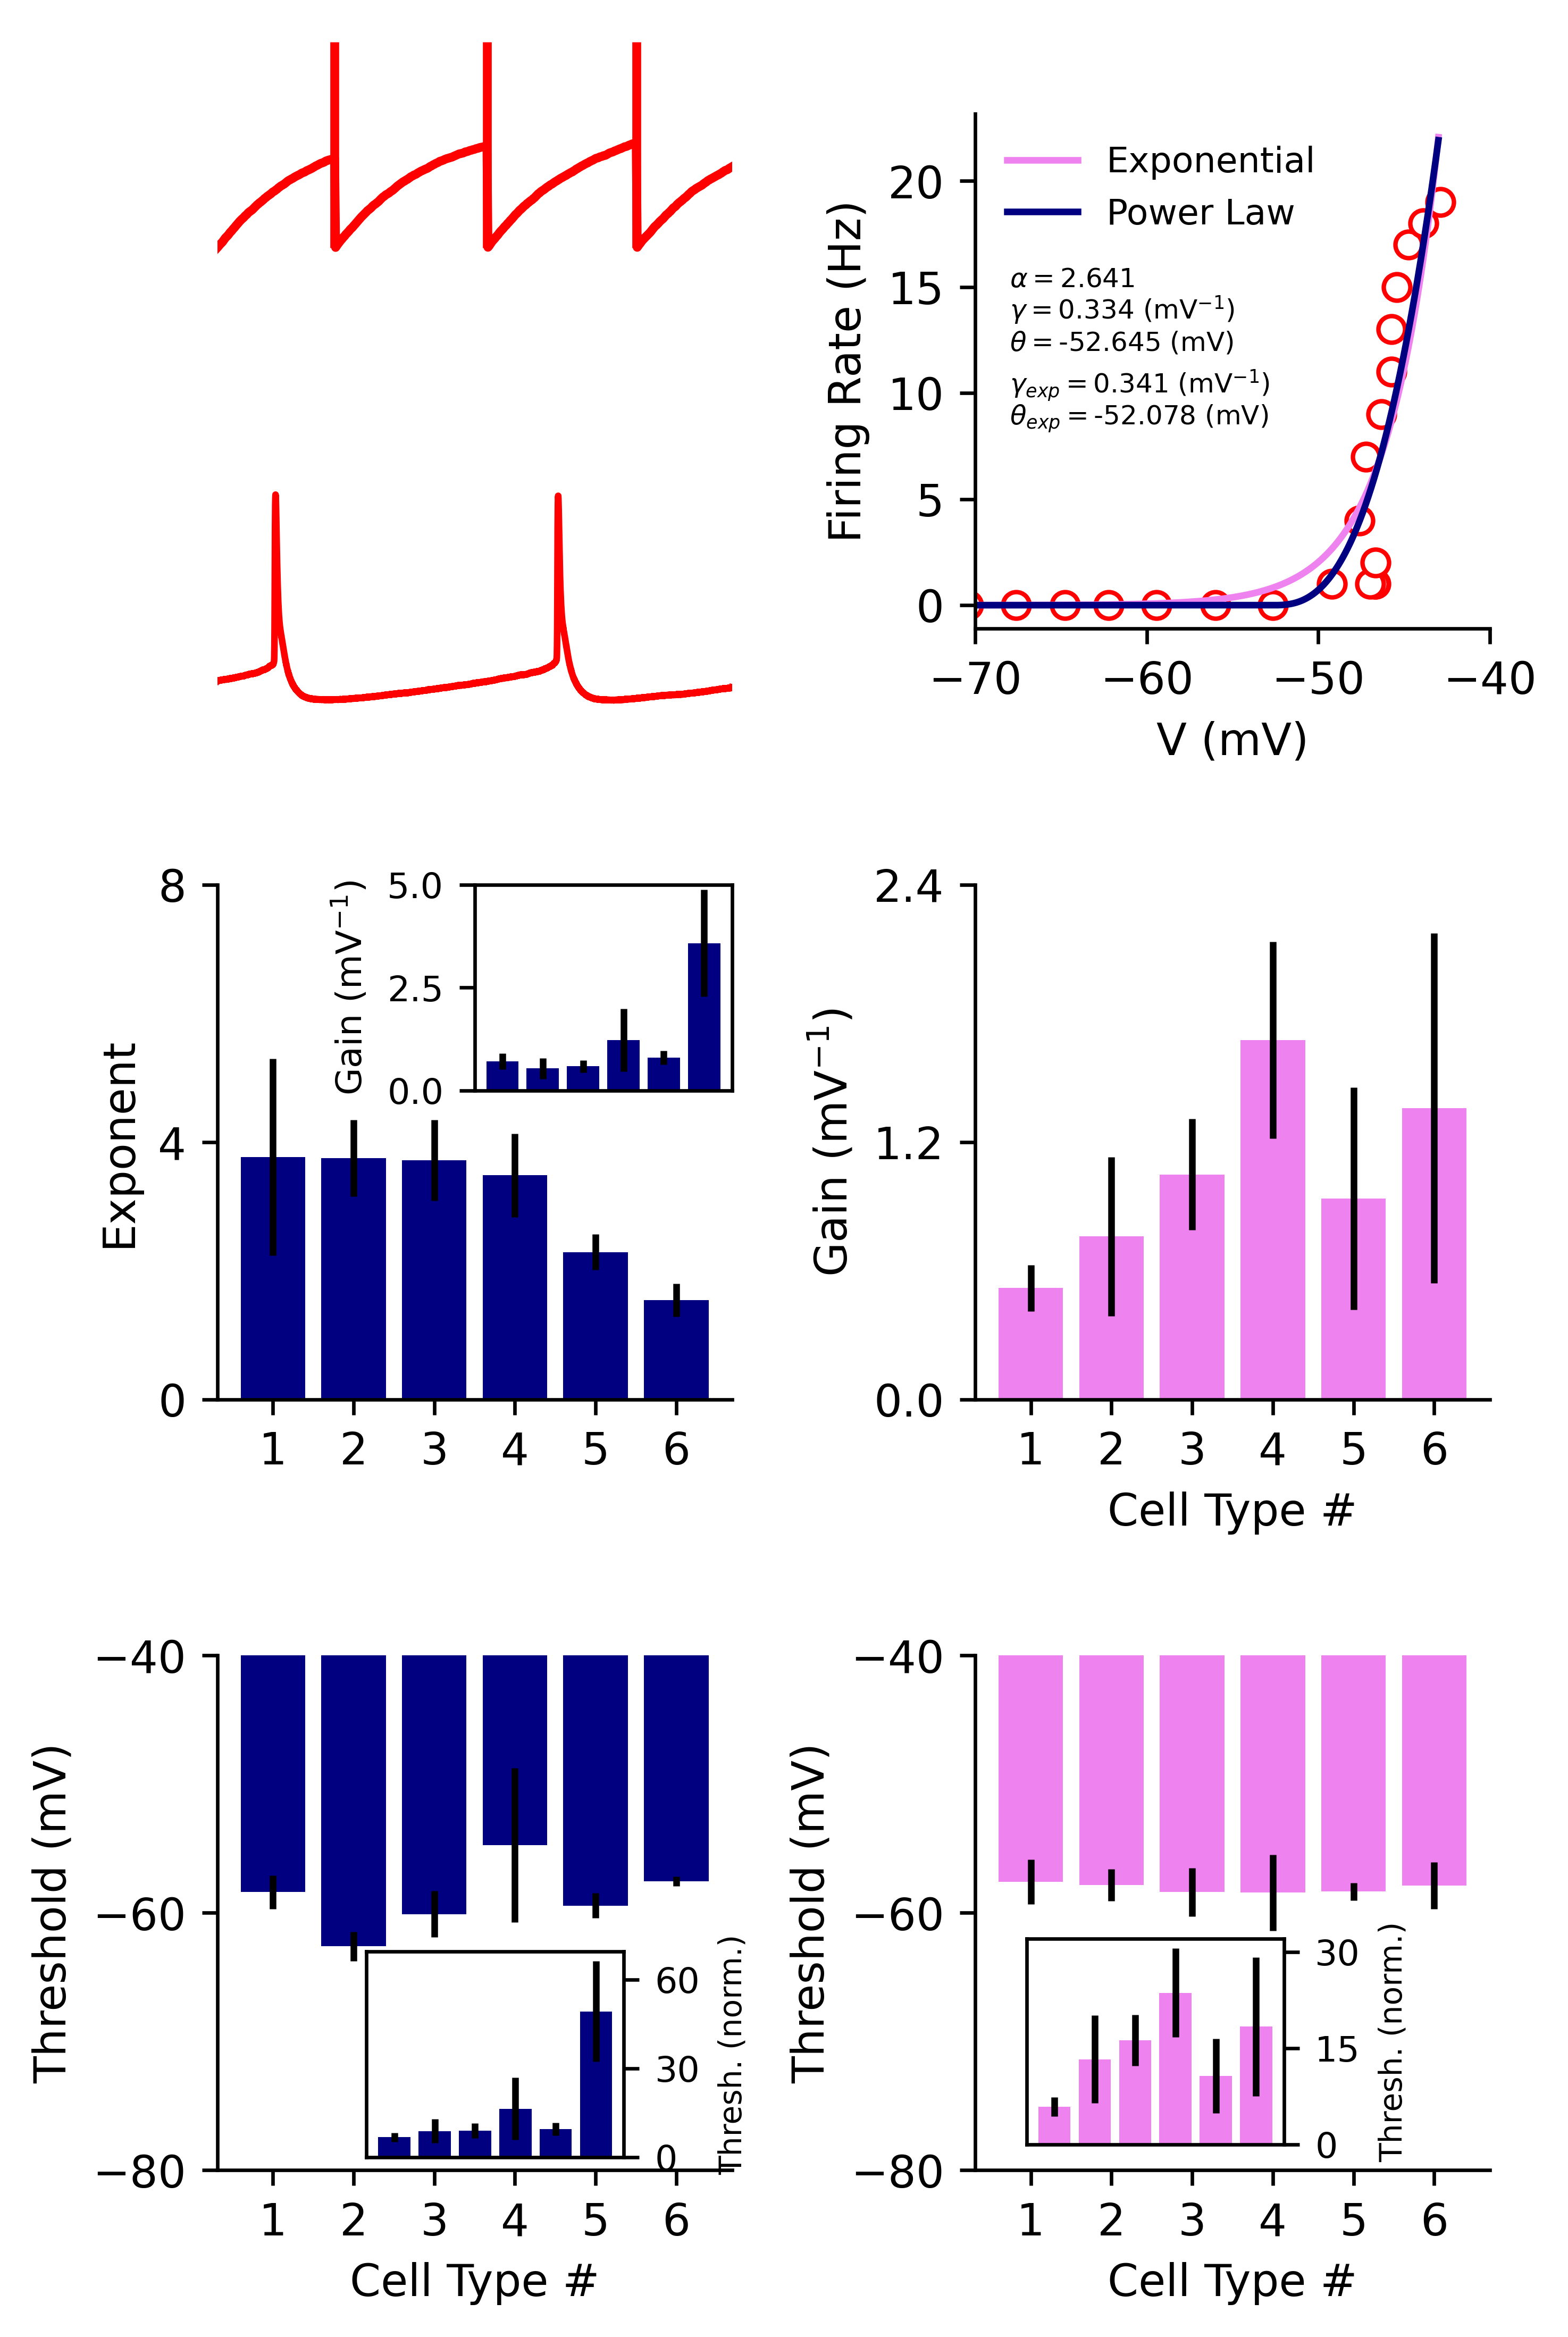

In [46]:
fontsize=10

f, ax = plt.subplots(3,2,figsize=(4.8,7.2),dpi=600, constrained_layout=True)

from mpl_toolkits.axes_grid1 import make_axes_locatable
idxSpk = np.where(spkTrain > 0)[0]
divider = make_axes_locatable(ax[0,0])
axShallow = divider.append_axes("top", size="100%", pad=0.)
axShallow.plot(T[0:500], memVol[0:500], '-r', linewidth = 2.0)
axShallow.vlines(T[idxSpk], 0, 4, color='r', linewidth = 2.0)
axShallow.set_xlim(T[0], T[500])
axShallow.axis('off')

axShallow2 = divider.append_axes("bottom", size="100%", pad=0.)
axShallow2.plot(t[index_range[0]+50000:index_range[0]+60000], v[index_range[0]+50000:index_range[0]+60000], color='r')
axShallow2.set_xlim(t[index_range[0]+50000],t[index_range[0]+60000])
axShallow2.axis('off')
ax[0,0].axis('off')


ax[0,1].plot(v_mean, fr_mean, 'or', markerfacecolor='white')
xdata = np.linspace(-85, -43, 1000)
ax[0,1].plot(xdata, fit_exponential(xdata, popt[0], popt[1]), color='violet', label='Exponential')
ax[0,1].plot(xdata, fit_power_law(xdata, popt1[0], popt1[1], thres), color='navy', label='Power Law')
ax[0,1].text(-68, 15, '$\\alpha=$'+str(popt1[1].round(3)), fontsize=6)
ax[0,1].text(-68, 13.5, '$\\gamma=$'+str(popt1[0].round(3))+' (mV$^{-1}$)', fontsize=6)
ax[0,1].text(-68, 12, '$\\theta=$'+str(thres.round(3))+' (mV)', fontsize=6)
ax[0,1].text(-68, 10, '$\\gamma_{exp}=$'+str(popt[1].round(3))+' (mV$^{-1}$)', fontsize=6)
ax[0,1].text(-68, 8.5, '$\\theta_{exp}=$'+str(popt[0].round(3))+' (mV)', fontsize=6)
ax[0,1].set_xlabel('V (mV)')
ax[0,1].set_ylabel('Firing Rate (Hz)')
ax[0,1].set_xlim(-70, -40)
ax[0,1].legend(frameon=False, loc='upper left', fontsize=8)
ax[0,1].set_aspect(1./ax[0,1].get_data_ratio())


ax[1,0].bar(np.arange(1, 7, 1), mean_exponent_pl, color='navy')
ax[1,0].errorbar(np.arange(1, 7, 1), mean_exponent_pl, var_exponent_pl, ecolor='k', linestyle='')
ax[1,0].set_ylabel('Exponent', fontsize=fontsize)
yticks = np.array([0.0, 4.0, 8.0])
xticks = np.arange(1, 7, 1)
ax[1,0].set_xticks(xticks)
ax[1,0].set_yticks(yticks)
ax[1,0].set_ylim(yticks[0], yticks[-1])
inset_ax = ax[1, 0].inset_axes([0.5, 0.6, 0.5, 0.4])
inset_ax.bar(np.arange(1, 7, 1), mean_gain_pl, color='navy')
inset_ax.errorbar(np.arange(1, 7, 1), mean_gain_pl, var_gain_pl, ecolor='k', linestyle='')
inset_ax.set_ylabel('Gain (mV$^{-1}$)', fontsize=8)
yticks = np.array([0.0, 2.5, 5.0])
xticks = np.arange(1,7,1)
inset_ax.set_xticks([])
inset_ax.set_yticks(yticks)
inset_ax.set_ylim(yticks[0], yticks[-1])
inset_ax.tick_params(axis='both', which='major', labelsize=8)
ax[1,0].set_aspect(1./ax[1,0].get_data_ratio())


ax[1,1].bar(np.arange(1, 7, 1), mean_gain_exp, color='violet')
ax[1,1].errorbar(np.arange(1, 7, 1), mean_gain_exp, var_gain_exp, ecolor='k', linestyle='')
ax[1,1].set_ylabel('Gain (mV$^{-1}$)', fontsize=fontsize)
ax[1,1].set_xlabel('Cell Type #', fontsize=fontsize)
yticks = np.array([0.0, 1.2, 2.4])
xticks = np.arange(1,7,1)
ax[1,1].set_xticks(xticks)
ax[1,1].set_yticks(yticks)
ax[1,1].set_ylim(yticks[0], yticks[-1])
ax[1,1].set_aspect(1./ax[1,1].get_data_ratio())


ax[2,0].bar(np.arange(1, 7, 1), mean_threshold_pl, color='navy')
ax[2,0].errorbar(np.arange(1, 7, 1), mean_threshold_pl, var_threshold_pl, ecolor='k', linestyle='')
ax[2,0].set_ylabel('Threshold (mV)', fontsize=fontsize)
yticks = np.array([-80, -60, -40])
xticks = np.arange(1,7,1)
ax[2,0].set_xticks(xticks)
ax[2,0].set_yticks(yticks)
# ax[2,0].tick_params(axis='both', which='major', labelsize=8)
ax[2,0].set_ylim(yticks[0], yticks[-1])
ax[2,0].set_xlabel('Cell Type #', fontsize=fontsize)
inset_ax = ax[2, 0].inset_axes([0.29, 0.025, 0.5, 0.4])
inset_ax.bar(np.arange(1, 7, 1), mean_gain_rescaled_pl, color='navy')
inset_ax.errorbar(np.arange(1, 7, 1), mean_gain_rescaled_pl, var_gain_rescaled_pl, ecolor='k', linestyle='')
yticks = np.array([0, 30, 60])
xticks = np.arange(1,7,1)
inset_ax.set_xticks([])
inset_ax.set_yticks(yticks)
inset_ax.set_ylabel('Thresh. (norm.)', fontsize=7)
inset_ax.tick_params(axis='both', which='major', labelsize=8)
inset_ax.yaxis.tick_right()
inset_ax.yaxis.set_label_position("right")
ax[2,0].set_aspect(1./ax[2,0].get_data_ratio())


ax[2,1].bar(np.arange(1, 7, 1), mean_thres_exp, color='violet')
ax[2,1].errorbar(np.arange(1, 7, 1), mean_thres_exp, var_thres_exp, ecolor='k', linestyle='')
ax[2,1].set_ylabel('Threshold (mV)', fontsize=fontsize)
ax[2,1].set_xlabel('Cell Type #', fontsize=fontsize)
yticks = np.array([-80.0, -60.0, -40.0])
xticks = np.arange(1,7,1)
ax[2,1].set_xticks(xticks)
ax[2,1].set_yticks(yticks)
ax[2,1].set_ylim(yticks[0], yticks[-1])
inset_ax1 = ax[2, 1].inset_axes([0.1, 0.05, 0.5, 0.4])
inset_ax1.bar(np.arange(1, 7, 1), mean_gain_rescaled_exp, color='violet')
inset_ax1.errorbar(np.arange(1, 7, 1), mean_gain_rescaled_exp, var_gain_rescaled_exp, ecolor='k', linestyle='')
yticks = np.array([0, 15, 30])
inset_ax1.yaxis.tick_right()
inset_ax1.set_xticks([])
inset_ax1.set_yticks(yticks)
inset_ax1.tick_params(axis='both', which='major', labelsize=8)
inset_ax1.set_ylabel('Thresh. (norm.)', fontsize=7)
inset_ax1.yaxis.tick_right()
inset_ax1.yaxis.set_label_position("right")
ax[2,1].set_aspect(1./ax[2,1].get_data_ratio())


sns.despine(ax=ax[0, 0])
sns.despine(ax=ax[0, 1])
sns.despine(ax=ax[1, 0])
sns.despine(ax=ax[1, 1])
sns.despine(ax=ax[2, 0])
sns.despine(ax=ax[2, 1])

# f.savefig('./Figures/Figure1.pdf', format='pdf')
# plt.show()


In [193]:
len(T)

1001

[Text(1, 0, '8'),
 Text(2, 0, '4'),
 Text(3, 0, '6'),
 Text(4, 0, '2'),
 Text(5, 0, '3'),
 Text(6, 0, '5')]

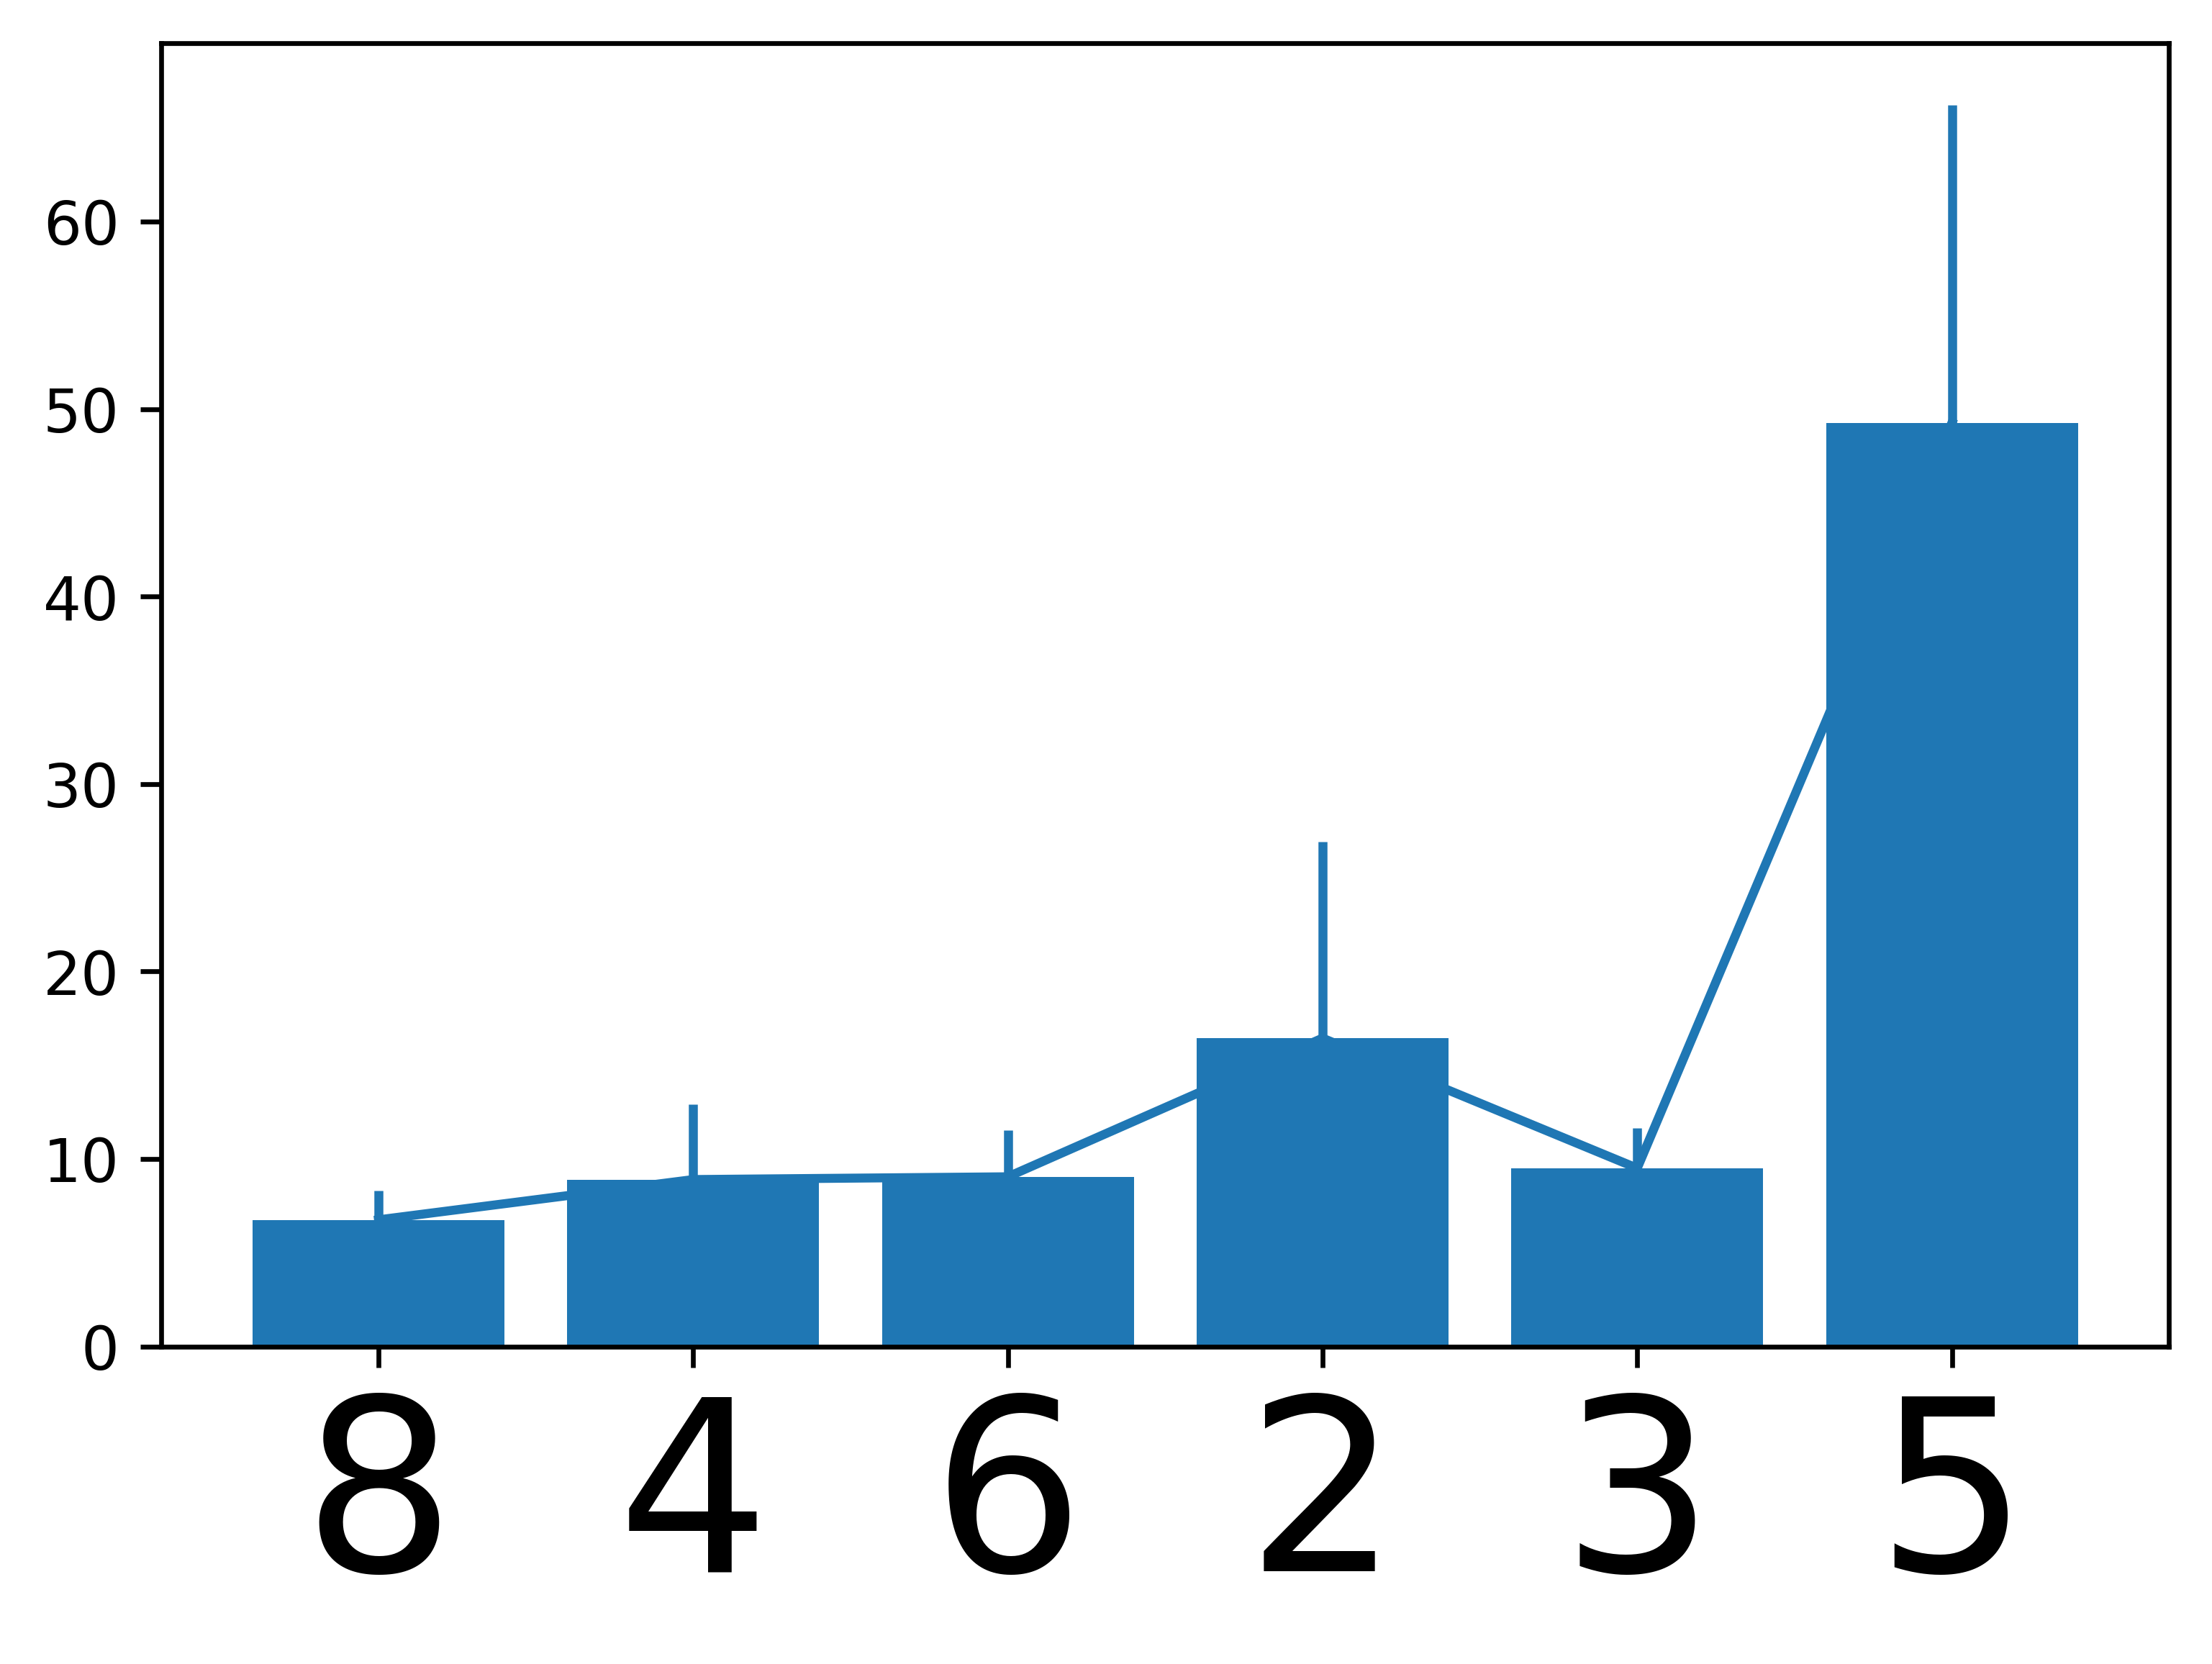

In [66]:
XTICKS = {'8', '2', '3', '4', '5', '6'}
ff, ax = plt.subplots(1,1,dpi=600)
ax.bar(np.arange(1,7,1), mean_gain_rescaled_pl)
ax.errorbar(np.arange(1,7,1), mean_gain_rescaled_pl, var_gain_rescaled_pl)
xticks = np.arange(1,7,1)
ax.set_xticks(xticks)
ax.set_xticklabels(XTICKS, fontsize=40)

<ErrorbarContainer object of 3 artists>

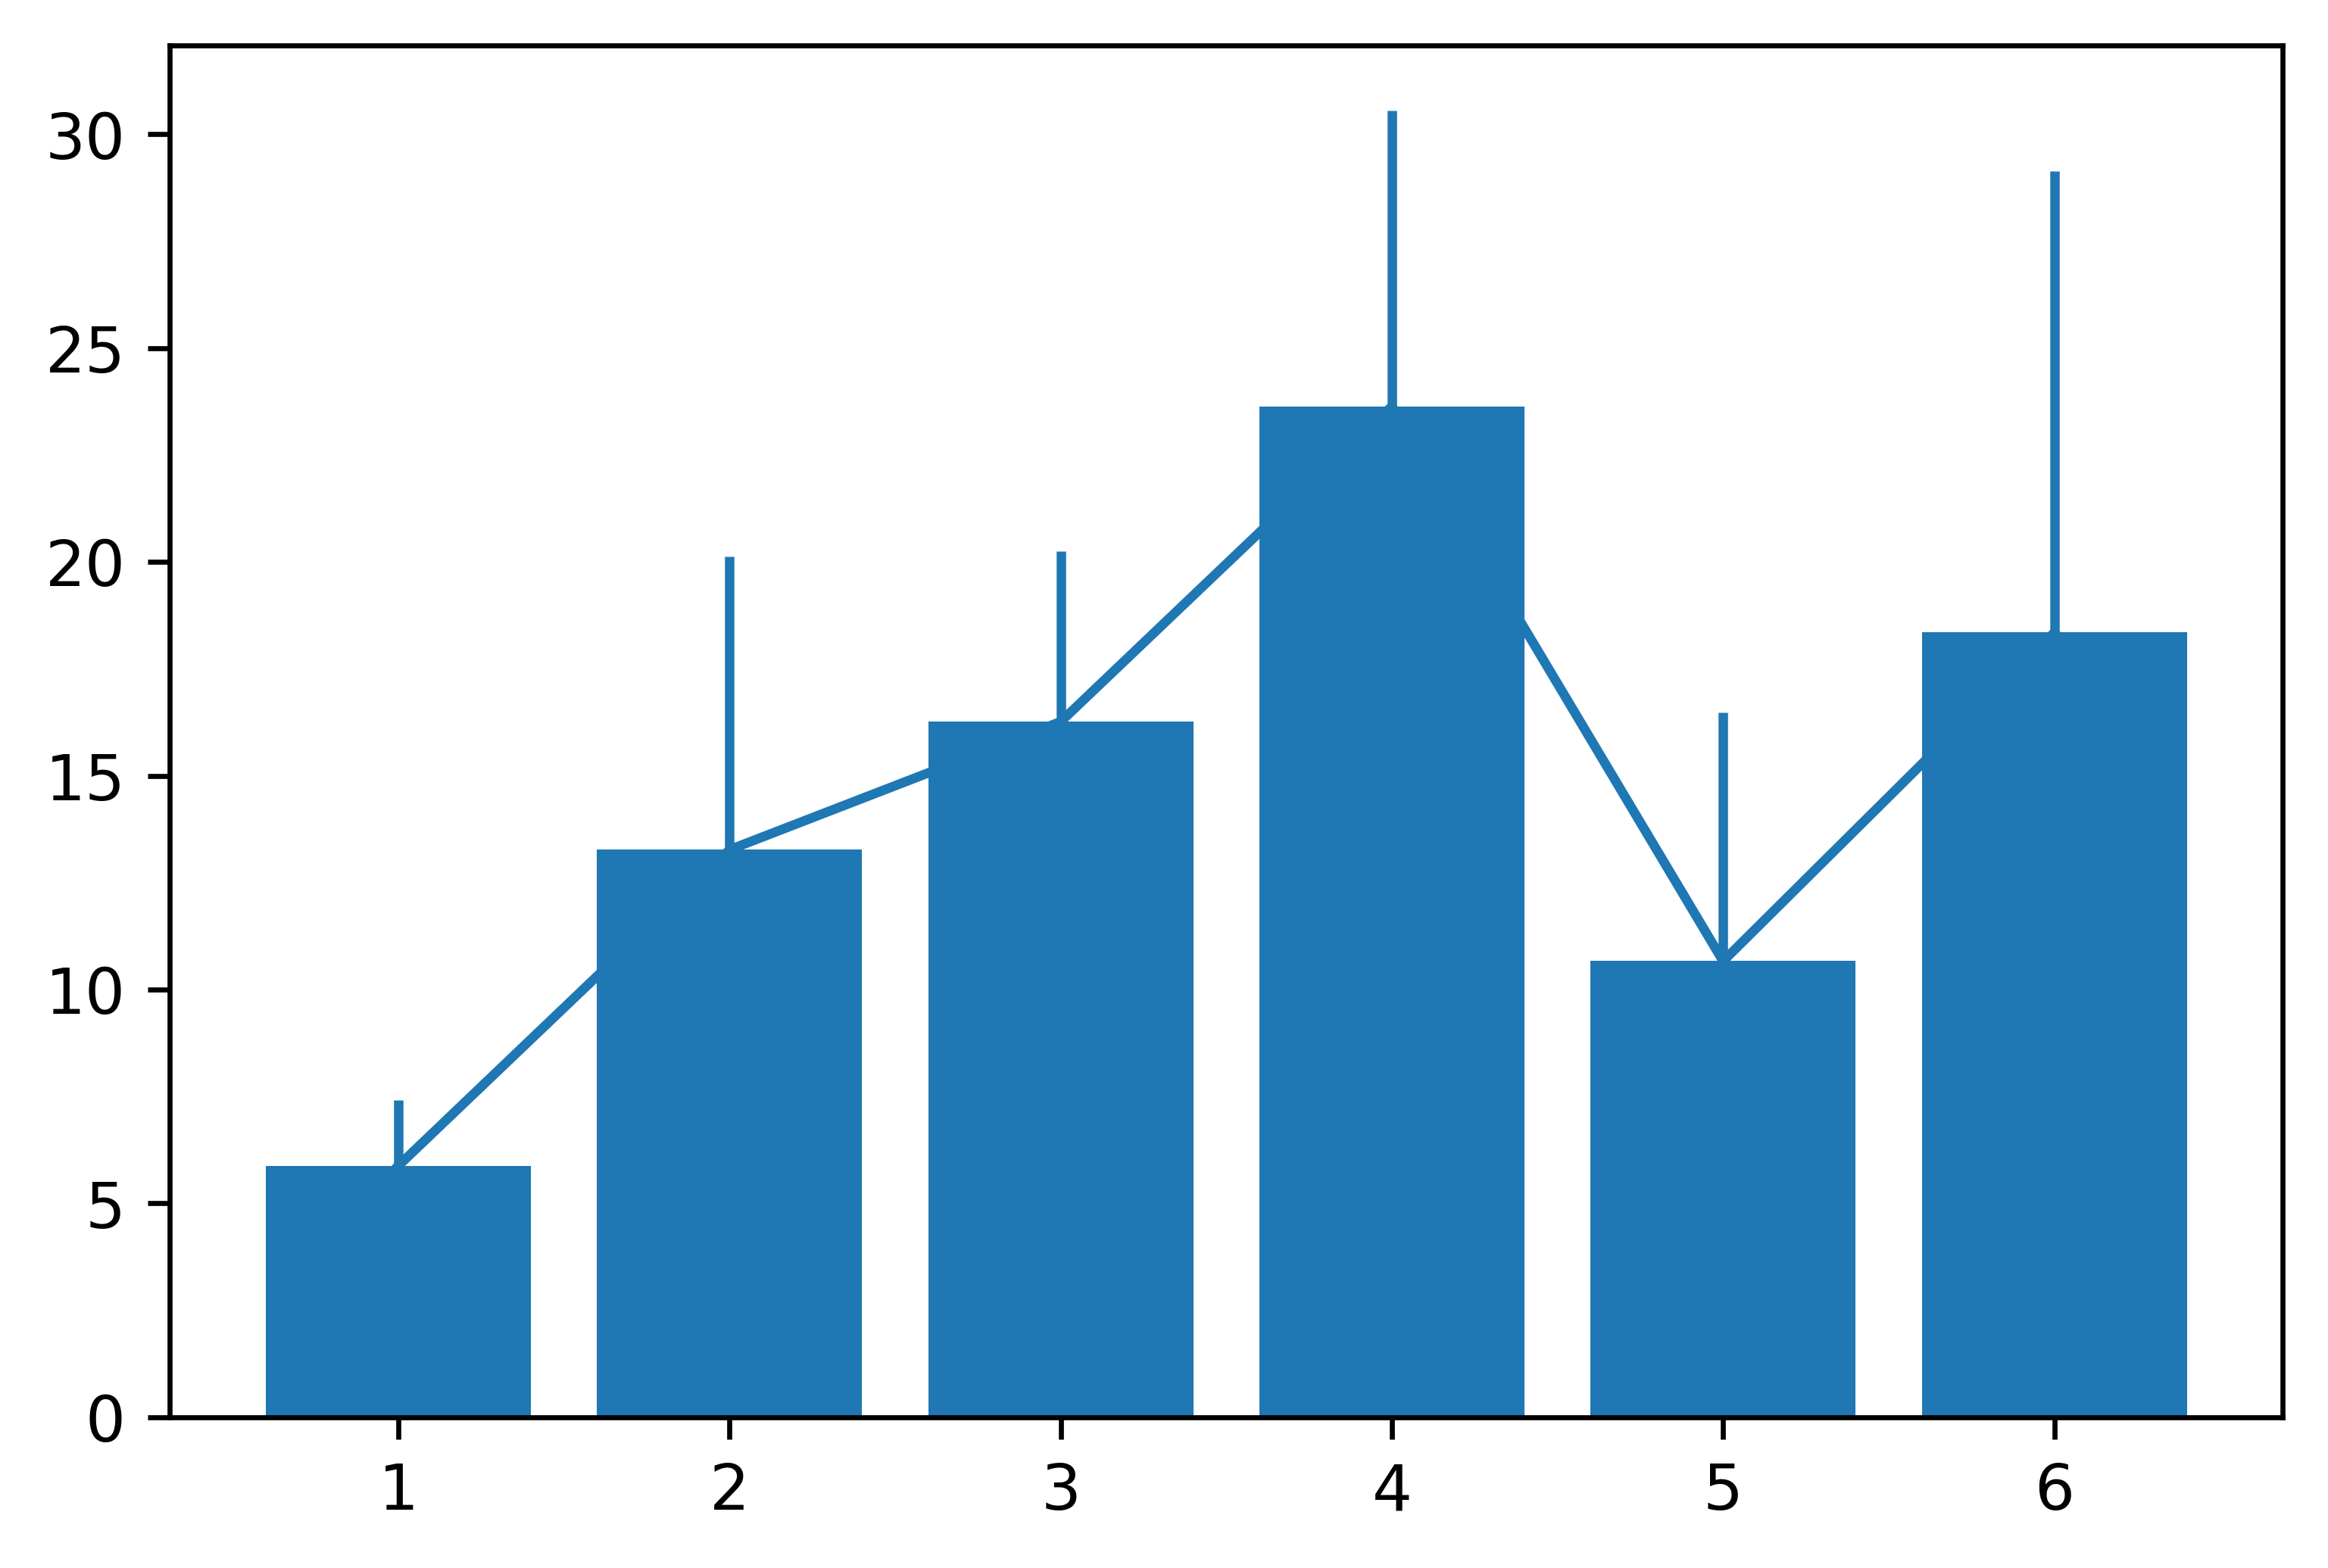

In [9]:
plt.figure(dpi=600)
plt.bar(np.arange(1,7,1), mean_gain_rescaled_exp)
plt.errorbar(np.arange(1,7,1), mean_gain_rescaled_exp, var_gain_rescaled_exp)

In [32]:
mean_exponent_pl

array([-58.38165894, -62.6025327 , -60.09370742, -54.74299385,
       -59.43485387, -57.54987869])

(-80.0, -40.0)

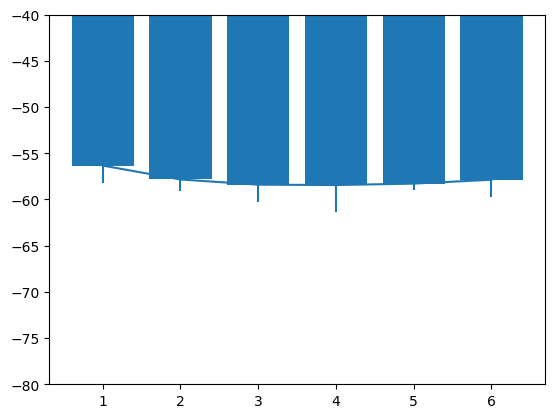

In [181]:
plt.bar(np.arange(1, 7, 1), mean_thres_exp[idx])
plt.errorbar(np.arange(1, 7, 1), mean_thres_exp[idx], var_thres_exp[idx])
plt.ylim(-80,-40)

(0.0, 3.0)

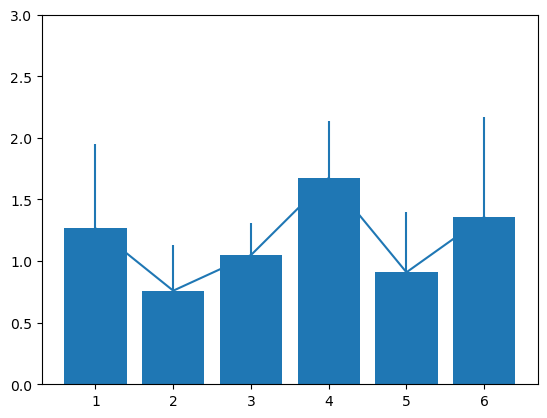

In [167]:
plt.bar(np.arange(1, 7, 1), mean_gain_exp[idx])
plt.errorbar(np.arange(1, 7, 1), mean_gain_exp[idx], var_gain_exp[idx])
plt.ylim(0,3)

In [12]:
file_in_folder = sorted(glob.glob('/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 1/*.np[yz]'))
data = np.load(file_in_folder[1])
file_in_folder

['/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 1/ViSI_Layer_5_Sim1-Cre_KJ18_Spiny.npz',
 '/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 1/ViSI_Layer_6a_6b_Ctgf-T2A-dgCre_Spiny.npz',
 '/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 1/ViSp_Layer 6b_Ctgf_T2A_dgCre.npz',
 '/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 1/ViSp_Layer_4_Scnn1a_Tg2_Cre_Spiny.npz',
 '/Users/siddharthpaliwal/Library/CloudStorage/GoogleDrive-siddharth.paliwal@stonybrook.edu/My Drive/Academics/Data/Data Fluctuation Impact/Figure 1/ViSp_Layer_5_Scnn1a_Tg2_Cre_Spiny.npz',
 '/Users/siddharthpaliwal/Library/CloudStorage/GoogleDriv

In [13]:
len(data['arr_2'])

6

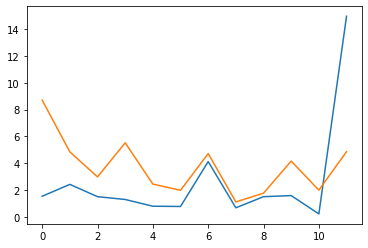

In [93]:
plt.plot(data['arr_5'])
plt.plot(data['arr_2'])
# np.nanmean(data['arr_1'])

In [68]:
data['arr_2'][2]

20.542443291950743